<a href="https://colab.research.google.com/github/aleehassett/MACS-33002/blob/main/33002_P1_CadiovascularDiseaseClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Project: Cardiovascular Disease Classification
#### Authors: Grishma Bhattarai & Annie Lee-Hassett

**Context:**  According to the World Health Organization (WHO), cardiovascular diseases (CVDs) are the leading cause of death globally, taking an estimated 17.9 million lives each year-- a whopping 32% of all deaths worldwide. Also known as the “silent killer,” cardiovascular diseases tend to have no warning signs or symptoms before a patient experiences a cardiac event like a heart attack or stroke. CVDs are fatal medical issues, and prompt treatment is crucial. Early action can significantly reduce complications and deaths worldwide. CVDs classification and prognosis is therefore, important, in order for them to be treated promptly to avoid irreversible damage or death. 

**Dataset:** This dataset is used to predict whether a patient is likely to get a cardiovascular disease based on the input parameters like age, gender, blood pressure, and physical activity. Each row in the data is an instance of a patient's records. 

*Source: https://www.kaggle.com/datasets/sulianova/cardiovascular-disease-dataset*

![picture](https://www.olympiabenefits.com/hubfs/Vega/Blog%20Pages/Medical%20Expenses/What%20is%20Cardiovascular%20Disease%20-%20A%20Complete%20Overview.png) 

## Libraries

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn import tree

## Dataset Attributes

Data description
There are 3 types of input features:

I. Objective: factual information;

II. Examination: results of medical examination;

III. Subjective: information given by the patient.

Features:
1. ID: Unique Identification Number
2. Age: Objective Feature (age, int (days))
3. Height: Objective Feature (height, int (cm))
4. Weight: Objective Feature (weight, float (kg))
5. Gender: Objective Feature (gender, categorical code, 1: women, 2: men) 
6. Systolic blood pressure: Examination Feature (ap_hi, int)
7. Diastolic blood pressure: Examination Feature (ap_lo, int)
8. Cholesterol: Examination Feature (cholesterol, 1: normal, 2: above normal, 3: well above normal)
9. Glucose: Examination Feature (gluc, 1: normal, 2: above normal, 3: well above normal)
10. Smoking: Subjective Feature (smoke, binary)
11. Alcohol intake: Subjective Feature (alco, binary)
12. Physical activity: Subjective Feature (active, binary)
13. Presence or absence of cardiovascular disease: **Target Variable** (cardio, binary)

**Categorical Features:** gender, cholestrol, gluc, smoke, alco, active, cardio

**Continuous Features:** age, height, weight, ap_hi, ap_lo

*Note: All of the dataset values were collected at the moment of medical examination.*


## Exploratory Data Analysis

In [ ]:
#load the dataframe
data = pd.read_csv('cardio_train.csv', sep=';')
data.head(5)

FileNotFoundError: ignored

In [ ]:
data.shape #(rows, columns)

In [ ]:
#duplication check
data.duplicated().sum()

In [ ]:
#convert age from days to years
data['age'] = data['age']/365
data.head(5)

In [ ]:
data.info()

Since there are no null values in any of the variables, we do not have to drop any observations yet. 

For continuous variables, we look at the summary statistics and the distribution.

In [ ]:
data[['age', 'height', 'weight', 'ap_hi', 'ap_lo']].describe()

In [ ]:
plt.style.use('ggplot')
continuousVar = ['age','weight','height','ap_lo', 'ap_hi']
data[continuousVar].boxplot()
plt.title("Numerical Variable Distribution", fontsize=12)
plt.show()

We see presence of some weird outliers for the continuous variables. Hence, we create a function to remove outliers:

In [ ]:
def outliersRemoval(var):
    q75,q25 = np.percentile(data[var],[75,25])
    quartile = q75 - q25
    
    maxm = q75 + (1.5 * quartile)
    minm = q25 - (1.5 * quartile)
    data.loc[data[var] < minm, var] = np.nan
    data.loc[data[var] > maxm, var] = np.nan
    data.isnull().sum()

In [ ]:
outliersRemoval('age')
data = data.dropna(axis = 0)
outliersRemoval('weight')
data = data.dropna(axis = 0)
outliersRemoval('height')
data = data.dropna(axis = 0)
outliersRemoval('ap_lo')
data = data.dropna(axis = 0)
outliersRemoval('ap_hi')
data = data.dropna(axis = 0)

In [ ]:
data[continuousVar].boxplot()
plt.title("Numerical Variable Distribution (Outliers Dropped)", fontsize=12)
plt.show()

In [ ]:
data.shape #new data shape after outliers are removed

We can visualize the distribution of numerical variables after outlier removal. 

In [ ]:
#histogram distribution
data.hist(column = 'age')
data.hist(column = 'weight')
data.hist(column = 'height')
data.hist(column = 'ap_lo')
data.hist(column = 'ap_hi')

For categorical variables, we visualize the summary statistics.

In [ ]:
sns.set_theme(style='white', palette='Accent')
fig, axes = plt.subplots(4, 2, figsize=(15, 20))

fig.suptitle('Categorical Variable Distribution')
fig.subplots_adjust(hspace=0.55, wspace=0.25)

ax1 = sns.countplot(ax=axes[0, 0], data=data, x='gender')
ax2 = sns.countplot(ax=axes[0, 1], data=data, x='cholesterol')
ax3 = sns.countplot(ax=axes[1, 0], data=data, x='gluc')
ax4 = sns.countplot(ax=axes[1, 1], data=data, x='smoke')
ax5 = sns.countplot(ax=axes[2, 0], data=data, x='alco')
ax6 = sns.countplot(ax=axes[2, 1], data=data, x='active')
ax7 = sns.countplot(ax=axes[3, 0], data=data, x='cardio')

fig.delaxes(ax=axes[3,1]) 

for i in range(1, 8):
    for p in globals()[f'ax{i}'].patches:
        globals()[f'ax{i}'].annotate('{:}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))

The distribution, especially for our Target Variable *cardio* looks balanced. Therefore, we do not need to run any further balance procedures. We now look at the correlation matrix for all the variables to see if we can identify some variables that might be particularly important.

We may note that the subjective variables (smoking, alcohol intake, and activity status), have very skewed responses. 


In [ ]:
plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(data.corr(), vmin=0, vmax=1, cmap='PuBu', annot=True, fmt='.2f')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

From the correlation heatmap we can see that there are some variables more correlated with *cardio* than others. Particularly, *ap_hi* i.e. systolic blood pressure looks the most correlated with a person's chances of getting a cardiovascular disease-- a fact that is supported by health literature. Therefore, *ap_hi* is an important feature.

Additionally, since the (systolic blood pressure, diastolic blood pressure) and (gender, height) are two variable combinations that are the most correlated with one another, we drop *ap_low* and *gender* to overcome possible issues of multicollinearity. We also drop *id* as it is a unique identifier. 


## Data Preprocessing

Now, we move on to **data preprocessing**.

Categorial variables: 
- cholesterol (multi, ordinal)
- gluc (multi, ordinal)
- smoke (binary)
- alco (binary)
- active (binary)
- **target variable:** cardio

Numerical variables:
- age
- height
- weight
- ap_hi

Since our multi-categorical variables are already ordinal and our remaining categorical variables are all binary, we can move on to scaling our numerical variables. 


In [ ]:
#construct feature matrix
X = data[['age', 'height', 'weight', 'ap_hi', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']]
y = data[['cardio']]

X.shape, y.shape

In [ ]:
#create train/test matrices
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [ ]:
#Standard Scaler Normalization:
#fit scaler
scaler = StandardScaler()
scaler.fit(X_train)

In [ ]:
#test scaled
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Model Training


#### Logistic Regression Classification Model 1
- Default Parameters

In [ ]:
#fit to logistic regression model
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_scaled, y_train.values.ravel())

#check the coefficients
coeff_df = pd.DataFrame(log_reg.coef_, columns=['age', 'height', 'weight', 'ap_hi', 'cholesterol', 'gluc', 'smoke', 'alco', 'active'])
coeff_df

#### Logistic Regression Classification Model 2
- Penalty: L1
- C-Value: 0.1

In [ ]:
#fit to logistic regression model
log_reg2 = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, random_state=42)
log_reg2.fit(X_train_scaled, y_train.values.ravel())

#check the coefficients
coeff_df2 = pd.DataFrame(log_reg2.coef_, columns=['age', 'height', 'weight', 'ap_hi', 'cholesterol', 'gluc', 'smoke', 'alco', 'active'])
coeff_df2

#### Logistic Regression Classification Model 3 w/o Subjective Features
Invidual reporting veracity at the doctor's office is often over/underrepresented during visits. We now create a new logistic regression model removing subjective features.

In [ ]:
log_reg3 = LogisticRegression(penalty='l1', C=1, solver='liblinear', random_state=42)
log_reg3.fit(X_train_scaled[:, 0:6], y_train.values.ravel())

#check the coefficients
coeff_df3 = pd.DataFrame(log_reg3.coef_, columns=['age', 'height', 'weight', 'ap_hi', 'cholesterol', 'gluc'])
coeff_df3

#### Decision Tree Classification Model 
-Default Parameters

In [ ]:
#decision tree classifier model
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train_scaled, y_train.values.ravel())

#### Random Forest Classification Model
- 100 Decision Trees
- Pruned w/ Maximum Depth of 5 

In [ ]:
#random forest classifier model
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_clf.fit(X_train_scaled, y_train.values.ravel())

## Model Evaluation

#### Logistic Regression Classification Model 1

In [ ]:
y_log_pred = log_reg.predict(X_test_scaled)
#classification report
print(classification_report(y_test, y_log_pred, digits=4))

A confusion matrix can be used to visualize the relationship between type I errors (false positives) vs type II errors (false negatives). Below, we note that the confusion matrix displays a higher rate of false negatives:

In [ ]:
#confusion matrix visualization
cm = confusion_matrix(y_test, y_log_pred)
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix LogReg Model 1')


We plot an ROC curve to observe the relationship between true and false positive rate. We aim for a curve that hugs the top left of the grid. The AUC measurement provides a quantified metric -- the closer to 1, the better the model fits. 

In [ ]:
#ROC curve
lr_prob = log_reg.predict_proba(X_test_scaled)
lr_prob = lr_prob[:, 1]
fpr, tpr, thresholds = roc_curve(y_test,  lr_prob)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve Logistic Regression Model 1')
auc = np.trapz(tpr,fpr)
print('AUC Metric =', auc)

#### Logistic Regression Classification Model 2

In [ ]:
y_log2_pred = log_reg2.predict(X_test_scaled)
#classification report
print(classification_report(y_test, y_log2_pred, digits=4))

In [ ]:
#confusion matrix visualization
cm = confusion_matrix(y_test, y_log2_pred)
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix LogReg Model 2')

In [ ]:
#ROC curve
lr_prob2 = log_reg2.predict_proba(X_test_scaled)
lr_prob2 = lr_prob2[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, lr_prob2)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve Logistic Regression Model 2')
auc = np.trapz(tpr,fpr)
print('AUC Metric =', auc)

#### Logistic Regression Classification Model 3 w/o Subjective Features

In [ ]:
y_log3_pred = log_reg3.predict(X_test_scaled[:, 0:6])
#classification report
print(classification_report(y_test, y_log3_pred, digits=4))

In [ ]:
#confusion matrix visualization
cm = confusion_matrix(y_test, y_log3_pred)
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix LogReg Model 3')

In [ ]:
#ROC curve
lr_prob3 = log_reg3.predict_proba(X_test_scaled[:, 0:6])
lr_prob3 = lr_prob3[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, lr_prob3)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve Logistic Regression Model 3')
auc = np.trapz(tpr,fpr)
print('AUC Metric =', auc)

#### Decision Tree Classification Model

In [ ]:
y_dt_pred = clf.predict(X_test_scaled)
#classification report
print(classification_report(y_test, y_dt_pred, digits=4))

In [ ]:
#confusion matrix visualization
cm = confusion_matrix(y_test, y_dt_pred)
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix Decision Tree Model')

#### Random Forest Classification Model 

In [ ]:
y_rf_pred = rf_clf.predict(X_test_scaled)
#classification report
print(classification_report(y_test, y_rf_pred, digits=4))

In [ ]:
#confusion matrix visualization
cm = confusion_matrix(y_test, y_rf_pred)
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix Random Forest Classification Model')

In [ ]:
#ROC curve
rf_prob = rf_clf.predict_proba(X_test_scaled)
rf_prob = rf_prob[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, rf_prob)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve Random Forest Classifier Model')
auc = np.trapz(tpr,fpr)
print('AUC Metric =', auc)

### Model Evaluation Summary

In [ ]:
score_summary = {'Model Type':  ['Default Logistic Regression Model', 'Logistic Regression Model (L1, c-value: 0.1)', 'Logistic Regression Model w/o Subjective Features', 'Default Decision Tree Classifier Model', 'Pruned Random Forest Classifier Model'],
        'Accuracy': ['0.7269', '0.7270', '0.7260', '0.6326', '0.7275'],
        'AUC Metric': ['0.7921','0.7921','0.7901','NA','0.7949']}

summary = pd.DataFrame(score_summary, index=[1,2,3,4,5])

print(summary)

It seems that the pruned random forest classifier model has the highest accuracy rate, at 0.7275 and AUC metric, at 0.7949. 

## Error Analysis and Conclusion

From our evaluation, we see that for the **Logistic Regression Models**, the one with L1 penalty and c-value of 0.1 outperform the default Logistic Regression or the one w/o Subjective Features. The **Pruned Random Forest Classification Model** has the best performance scores among all 5 models, however, only by the 0.001th difference. We believe our Pruned Random Forest Model is the versatile algorithm for this noisy data, and thus, it outperforms the Logistic Regression Models with not a lot of preprocessing required.

**Error Analysis:** We believe the data has irreducible error in the form of **noise**. Our exploration found some extreme values for the continuous variables. Even after accounting for outliers, however, we still have some eccentric data for height and weight. For example, there are weights as low as 9.97 kg/22 lbs and a height of up to 250 cm/8.2 ft. Also, there are several instances where the combinations doesn't seem realistic-- eg. a female at 73.152 cm/2.4 ft and weighing 168 kg/370 lbs. Therefore, we believe this dataset has noise which might be affecting model performance. This is confirmed by our confusion matrices, which diplay higher rates of false positives than negatives. False positives are often caused by redundant or mislabeled data, such as described above.

Although recall and f-1 scores around the range of for 0.74 both classes are not the best scores of good model performance, our exploration on the internet revealed that the average f-1 score for both classes for this dataset (usability: 6.47) across several Kaggle submissions is approximately 0.70. Therefore, we are happy with our results. 

From our research, we found that **Feature Engineering** could be a way to work around noisy data. In the **Random Forest Classification Model** we could possibly also use **GridSearchCV** to pick the best performing parameters/ 
Additionally, models like  **Gradient Boosting** and **k-means Clustering** could possibly give better results. Hence, these could be avenues of further exploration.

In [ ]:
true = [1,0,1,0,1,0]
pred = [1,1,1,0,0,0]

AUC Metric = 0.6666666666666667


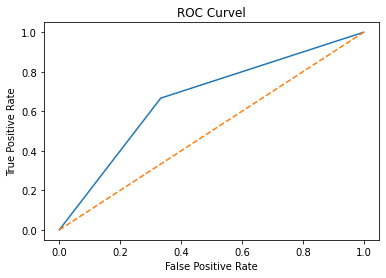

In [ ]:
fpr, tpr, thresholds = roc_curve(true, pred)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curvel')
auc = np.trapz(tpr,fpr)
print('AUC Metric =', auc)

In [ ]:
from sklearn.metrics import roc_auc_score
score = roc_auc_score(true, pred)
round(score,3)

0.667

In [ ]:
fpr = [0, 0/3, 1/3, 1/3, 2/3, 2/3, 3/3] 
tpr = [0, 1/3, 1/3, 2/3, 2/3, 3/3, 3/3]

AUC Metric = 0.6666666666666667


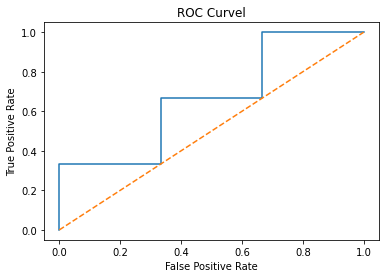

In [ ]:
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curvel')
auc = np.trapz(tpr,fpr)
print('AUC Metric =', auc)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
a= [3,9,4,2,7]
b= [2,7,4,3,6]
first = mean_absolute_error(a, b)
sec = mean_squared_error(a,b)
sec

1.4